**Access Dataset from Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Alzheimer

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/Alzheimer


In [ ]:
%ls

Demented/                  inception_ct_loss.png   inception_weights_ct.hdf5
inception_ct_accuracy.png  inception_dem.h5        inception_weights_dem.hdf5
inception_ct.h5            inception_dem_loss.png  NonDemented/


**Importing Libraries and dependencies**

In [ ]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Redefining size of each image of the dataset
IMAGE_SIZE = [229,229]

#Defining hyperparameters for training
epochs = 500
batch_size = 64

# **Image data Preprocessing**

***Classifying Categories***



In [ ]:
#Defining paths
dement_path = '/gdrive/My Drive/Alzheimer/Demented'
nondement_path = '/gdrive/My Drive/Alzheimer/NonDemented'

In [ ]:
#Use glob to pull the images
NonDemfiles = glob( nondement_path +'/*' )
Demfiles = glob( dement_path + '/*' )

In [ ]:
#Visualize file variable images
print("First 5 NonDem Files: ",NonDemfiles[0:5])
print("Total Count: ",len(NonDemfiles))
print("First 5 ModDem Files: ",Demfiles[0:5])
print("Total Count: ",len(Demfiles))

First 5 NonDem Files:  ['/gdrive/My Drive/Alzheimer/NonDemented/nonDem137.jpg', '/gdrive/My Drive/Alzheimer/NonDemented/nonDem101.jpg', '/gdrive/My Drive/Alzheimer/NonDemented/nonDem109.jpg', '/gdrive/My Drive/Alzheimer/NonDemented/nonDem181.jpg', '/gdrive/My Drive/Alzheimer/NonDemented/nonDem138.jpg']
Total Count:  200
First 5 ModDem Files:  ['/gdrive/My Drive/Alzheimer/Demented/mildDem143.jpg', '/gdrive/My Drive/Alzheimer/Demented/mildDem123.jpg', '/gdrive/My Drive/Alzheimer/Demented/mildDem9.jpg', '/gdrive/My Drive/Alzheimer/Demented/mildDem159.jpg', '/gdrive/My Drive/Alzheimer/Demented/mildDem62.jpg']
Total Count:  200


In [ ]:
Dem_labels = []
NonDem_labels = []

Dem_images=[]
NonDem_images=[]

for i in range(len(Demfiles)):
  image = cv2.imread(Demfiles[i]) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  image = cv2.resize(image,(229,229)) 
  Dem_images.append(image) 
  Dem_labels.append('Demented') 
for i in range(len(NonDemfiles)):
  image = cv2.imread(NonDemfiles[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(229,229))
  NonDem_images.append(image)
  NonDem_labels.append('NonDemented')

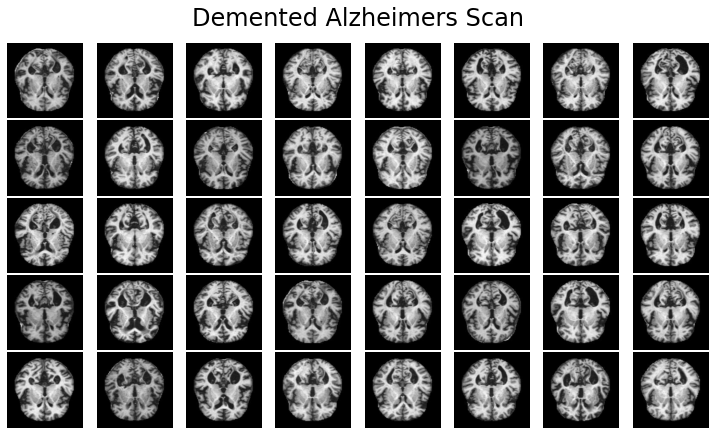

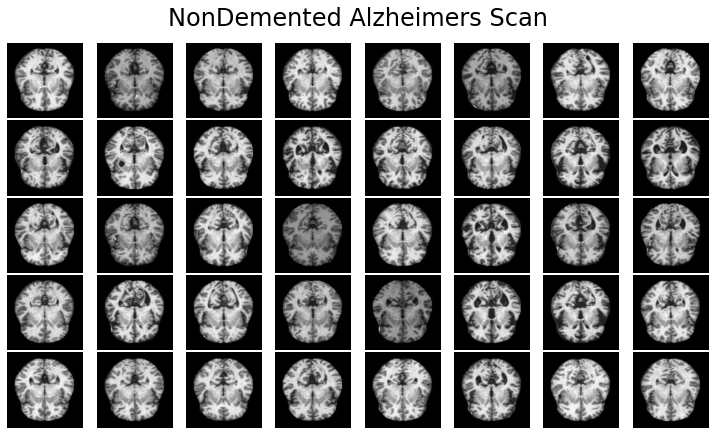

In [ ]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(Dem_images, 'Demented Alzheimers Scan')
plot_images(NonDem_images, 'NonDemented Alzheimers Scan')

In [ ]:
#Converting into arrays and normalize the colour values
Dem_images = np.array(Dem_images) / 255
NonDem_images = np.array(NonDem_images) / 255

***Splitting Dataset into test set and training set***

In [ ]:
Dem_x_train, Dem_x_test, Dem_y_train, Dem_y_test = train_test_split(
    Dem_images, Dem_labels, test_size=0.2)
NonDem_x_train, NonDem_x_test, NonDem_y_train, NonDem_y_test = train_test_split(
    NonDem_images, NonDem_labels, test_size=0.2)


X_train = np.concatenate((NonDem_x_train, Dem_x_train), axis=0)
X_test = np.concatenate((NonDem_x_test, Dem_x_test), axis=0)
y_train = np.concatenate((NonDem_y_train, Dem_y_train), axis=0)
y_test = np.concatenate((NonDem_y_test, Dem_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

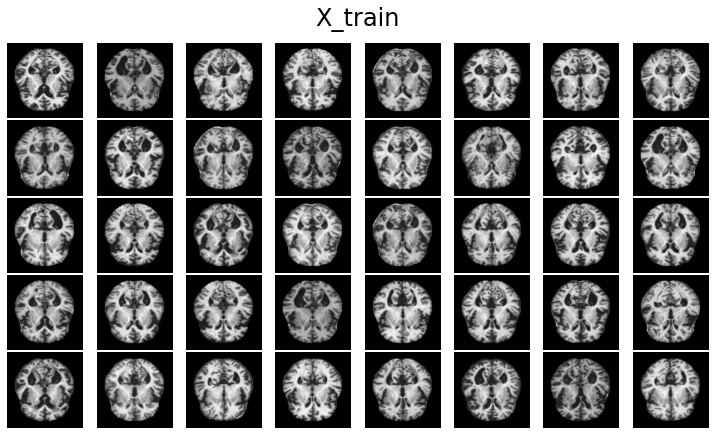

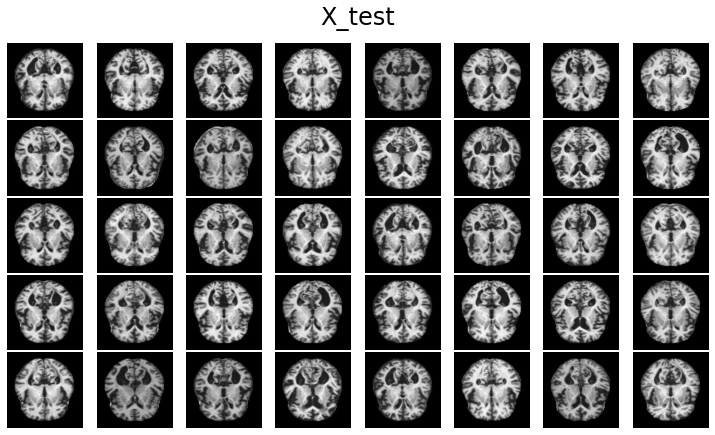

In [ ]:
plot_images(Dem_x_train, 'X_train')
plot_images(Dem_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

***Building and Visualizing Inception Model***

In [ ]:
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(229, 229, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.4)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [ ]:
#Visualize the model
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 229, 229, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 114, 114, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 114, 114, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 114, 114, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

# **Image Augmentation**

**Training images at various angles, flips,positions etc.**

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

**Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
5/5 [==============================] - 6s 1s/step - loss: 7.6929 - accuracy: 0.5000 - val_loss: 6.5631 - val_accuracy: 0.5000
Epoch 2/500
5/5 [==============================] - 5s 911ms/step - loss: 3.2730 - accuracy: 0.6469 - val_loss: 2.7121 - val_accuracy: 0.6375
Epoch 3/500
5/5 [==============================] - 5s 911ms/step - loss: 2.0385 - accuracy: 0.7250 - val_loss: 1.0598 - val_accuracy: 0.7875
Epoch 4/500
5/5 [==============================] - 5s 919ms/step - loss: 1.5237 - accuracy: 0.7656 - val_loss: 1.1121 - val_accuracy: 0.8625
Epoch 5/500
5/5 [==============================] - 5s 908ms/step - loss: 1.6884 - accuracy: 0.7563 - val_loss: 0.9094 - val_accuracy: 0.8250
Epoch 6/500
5/5 [==============================] - 5s 908ms/step - loss: 0.9945 - accuracy: 0.8031 - val_loss: 0.8014 - val_accuracy: 0.8625
Epoch 7/500
5/5 [==============================] - 5s 918ms/step - loss: 1.1152 - accuracy: 0.8031 - val_loss: 0.9532 - val_accuracy: 0.7875
Epoch 8/500
5/5 

In [ ]:
#Saving trained model and weights
model.save('xception_dem.h5')
model.save_weights('xception_weights_dem.hdf5')

In [ ]:
#Now load the saved model
model = load_model('xception_dem.h5')

***Predicting trained model on test set***

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

***Visualizing predicted classes***

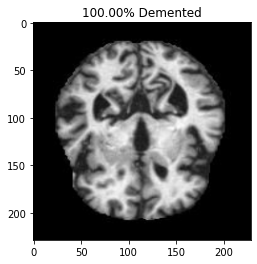

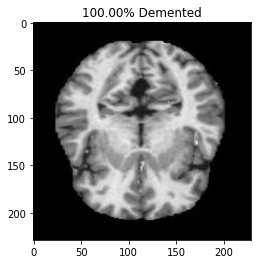

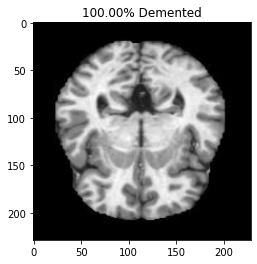

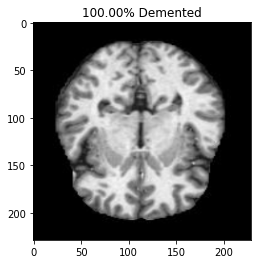

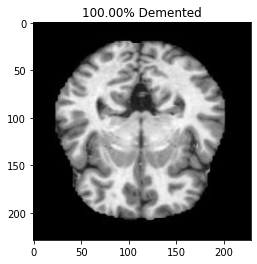

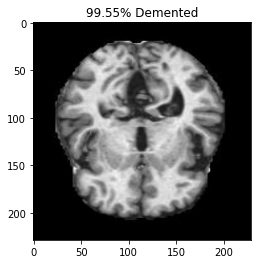

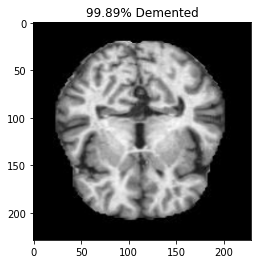

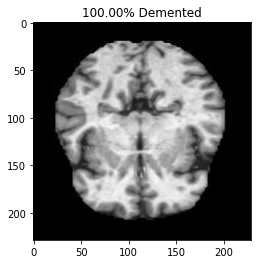

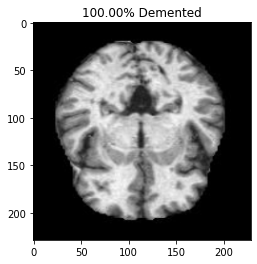

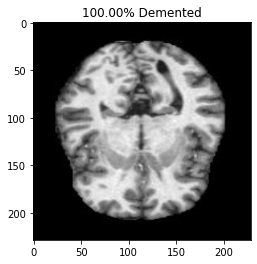

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% Demented')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonDemented')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

***ROC Graph***

In [ ]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

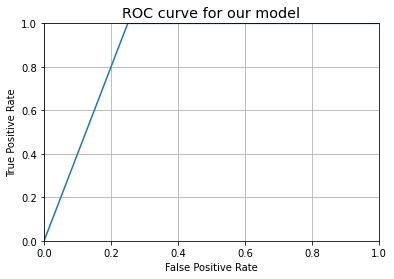

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


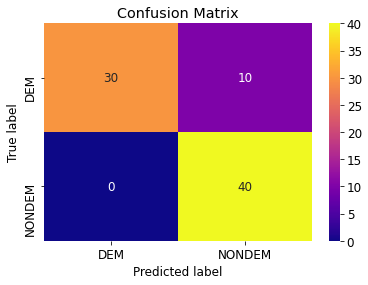

Confusion Matrix with Normalized Values


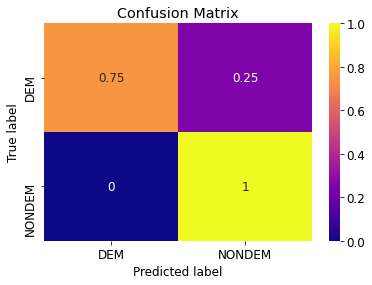

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['DEM','NONDEM']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        40
           1       0.80      1.00      0.89        40

    accuracy                           0.88        80
   macro avg       0.90      0.88      0.87        80
weighted avg       0.90      0.88      0.87        80



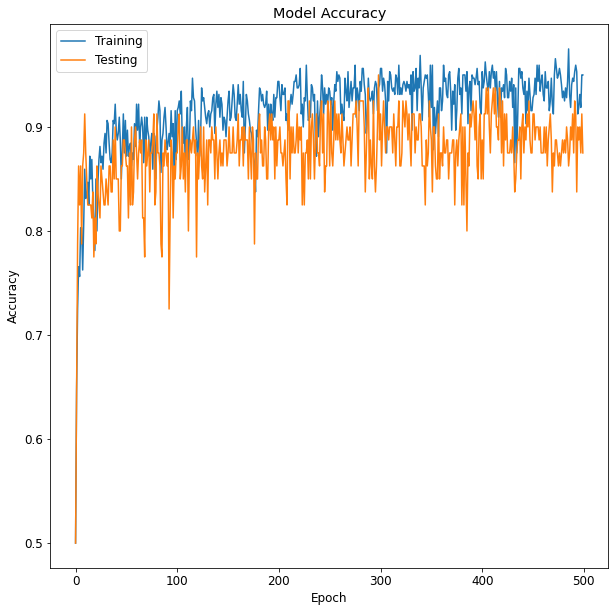

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_dem_accuracy.png')
plt.show()

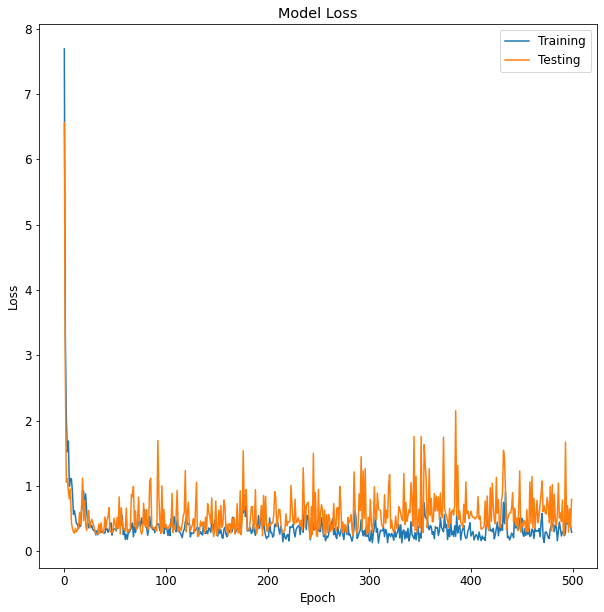

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_dem_loss.png')
plt.show()